# Import Library

In [2]:
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import librosa
import librosa.display
import cv2
from PIL import Image

from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, Dense, Flatten, Dropout, Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import utils as np_utils
import os
from os import listdir
from os.path import isfile, join
import copy
import random

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import MaxPool2D, Reshape, Concatenate
from tensorflow.keras.regularizers import l2

# Loading Data

In [3]:
W = 300
H = 300
label_to_class = {
    'COVID': 0,
    'FIBROSIS':       1,
    'NORMAL':    2,
    'TUBERCULOSIS': 3,
}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name='', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for label_name in os.listdir(dir_name):
        cls = label_to_class[label_name]

        
        for img_name in os.listdir('/'.join([dir_name, label_name])):
            img = load_img('/'.join([dir_name, label_name, img_name]), target_size=(W, H))
            img = img_to_array(img)
            Images.append(img)
            Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)

    return Images, Classes

## get images / labels

Images, Classes = get_images(dir_name="../input/ssd2-for-covid/SSD2")

Images.shape, Classes.shape

((3800, 300, 300, 3), (3800,))

# Visualizing Data

COVID 950 0.25


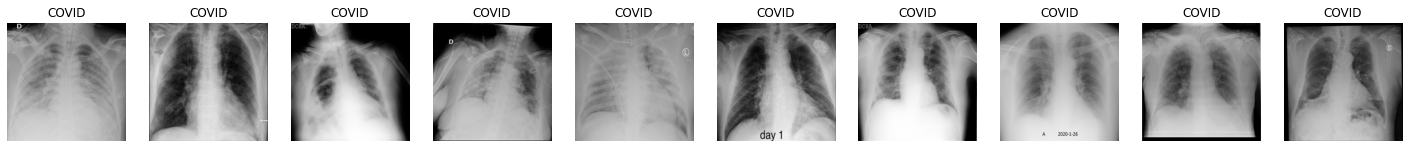

FIBROSIS 950 0.25


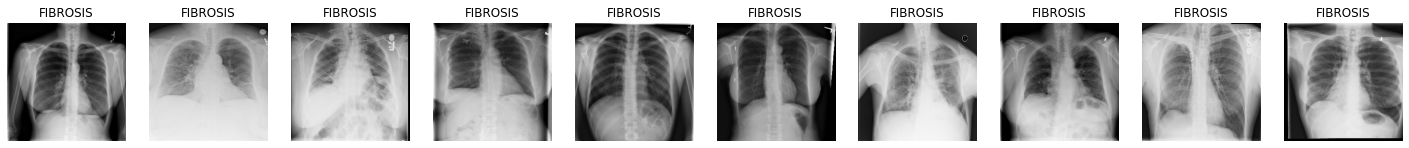

NORMAL 950 0.25


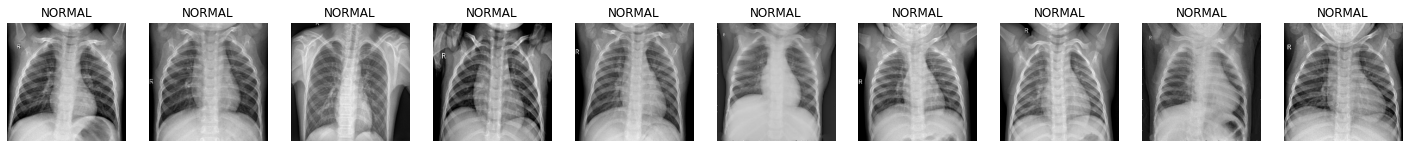

TUBERCULOSIS 950 0.25


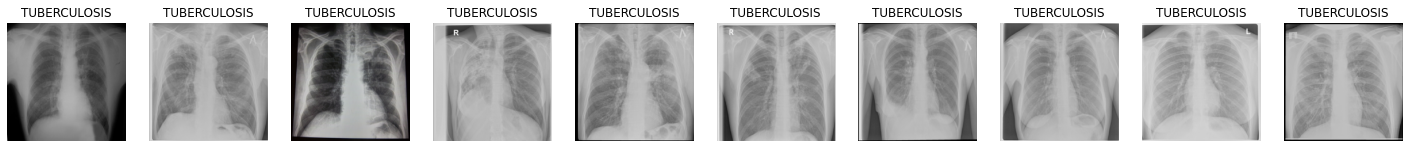

In [4]:
n_total_images = Images.shape[0]

for target_cls in [0,1,2,3]:
    
    indices = np.where(Classes == target_cls)[0] 
    n_target_cls = indices.shape[0]
    label = class_to_label[target_cls]
    print(label, n_target_cls, n_target_cls/n_total_images)

    n_cols = 10 
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):

        axs[i].imshow(np.uint8(Images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label)

    plt.show()

# Data Split

In [5]:
## split train / test

train_set, validation_test_set = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, random_state=42, shuffle=False)
validation_set, test_set = train_test_split(validation_test_set, test_size=0.5, random_state=42, shuffle=False)

x_train = Images[train_set]
y_train = Classes[train_set]
x_validation = Images[validation_set]
y_validation = Classes[validation_set]
x_test = Images[test_set]
y_test = Classes[test_set]

y_train = np_utils.to_categorical(y_train, n_classes)
y_validation = np_utils.to_categorical(y_validation, n_classes)
y_test = np_utils.to_categorical(y_test, n_classes)

In [6]:
image_data_generator = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        samplewise_center=True, 
        samplewise_std_normalization= True, 
        rescale=1./255,
        horizontal_flip=True,
        validation_split=0.2
    )

# Box

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer

def get_number_default_boxes(aspect_ratios, extra_box_for_ar_1=True):
    """ 
    """
    num_aspect_ratios = len(aspect_ratios)
    return num_aspect_ratios + 1 if (1.0 in aspect_ratios) and extra_box_for_ar_1 else num_aspect_ratios

def center_to_corner(boxes):
    """ 
    """
    temp = boxes.copy()
    temp[..., 0] = boxes[..., 0] - (boxes[..., 2] / 2)  # xmin
    temp[..., 1] = boxes[..., 1] - (boxes[..., 3] / 2)  # ymin
    temp[..., 2] = boxes[..., 0] + (boxes[..., 2] / 2)  # xmax
    temp[..., 3] = boxes[..., 1] + (boxes[..., 3] / 2)  # ymax
    return temp

def corner_to_center(boxes):
    """ 
    """
    temp = boxes.copy()
    width = np.abs(boxes[..., 0] - boxes[..., 2])
    height = np.abs(boxes[..., 1] - boxes[..., 3])
    temp[..., 0] = boxes[..., 0] + (width / 2)  # cx
    temp[..., 1] = boxes[..., 1] + (height / 2)  # cy
    temp[..., 2] = width  # xmax
    temp[..., 3] = height  # ymax
    return temp


def generate_default_boxes_for_feature_map(
    feature_map_size,
    image_size,
    offset,
    scale,
    next_scale,
    aspect_ratios,
    variances,
    extra_box_for_ar_1,
    clip_boxes=True,
):
    """ 
    """
    assert len(offset) == 2, "offset must be of len 2"

    grid_size = image_size / feature_map_size
    offset_x, offset_y = offset
    num_default_boxes = get_number_default_boxes(
        aspect_ratios,
        extra_box_for_ar_1=extra_box_for_ar_1
    )
    # 
    wh_list = []
    for ar in aspect_ratios:
        if ar == 1.0 and extra_box_for_ar_1:
            wh_list.append([
                image_size * np.sqrt(scale * next_scale) * np.sqrt(ar),
                image_size * np.sqrt(scale * next_scale) * (1 / np.sqrt(ar)),
            ])
        wh_list.append([
            image_size * scale * np.sqrt(ar),
            image_size * scale * (1 / np.sqrt(ar)),
        ])
    wh_list = np.array(wh_list, dtype=np.float)
    # get all center points of each grid cells
    cx = np.linspace(offset_x * grid_size, image_size - (offset_x * grid_size), feature_map_size)
    cy = np.linspace(offset_y * grid_size, image_size - (offset_y * grid_size), feature_map_size)
    cx_grid, cy_grid = np.meshgrid(cx, cy)
    cx_grid, cy_grid = np.expand_dims(cx_grid, axis=-1), np.expand_dims(cy_grid, axis=-1)
    cx_grid, cy_grid = np.tile(cx_grid, (1, 1, num_default_boxes)), np.tile(cy_grid, (1, 1, num_default_boxes))
    #
    default_boxes = np.zeros((feature_map_size, feature_map_size, num_default_boxes, 4))
    default_boxes[:, :, :, 0] = cx_grid
    default_boxes[:, :, :, 1] = cy_grid
    default_boxes[:, :, :, 2] = wh_list[:, 0]
    default_boxes[:, :, :, 3] = wh_list[:, 1]
    # 
    if clip_boxes:
        default_boxes = center_to_corner(default_boxes)
        x_coords = default_boxes[:, :, :, [0, 2]]
        x_coords[x_coords >= image_size] = image_size - 1
        x_coords[x_coords < 0] = 0
        default_boxes[:, :, :, [0, 2]] = x_coords
        y_coords = default_boxes[:, :, :, [1, 3]]
        y_coords[y_coords >= image_size] = image_size - 1
        y_coords[y_coords < 0] = 0
        default_boxes[:, :, :, [1, 3]] = y_coords
        default_boxes = corner_to_center(default_boxes)
    #
    default_boxes[:, :, :, [0, 2]] /= image_size
    default_boxes[:, :, :, [1, 3]] /= image_size
    #
    variances_tensor = np.zeros_like(default_boxes)
    variances_tensor += variances
    default_boxes = np.concatenate([default_boxes, variances_tensor], axis=-1)
    return default_boxes

class DefaultBoxes(Layer):
    """ 
    """

    def __init__(
        self,
        image_shape,
        scale,
        next_scale,
        aspect_ratios,
        variances,
        offset=(0.5, 0.5),
        extra_box_for_ar_1=True,
        clip_boxes=True,
        **kwargs
    ):
        self.image_shape = image_shape
        self.scale = scale
        self.next_scale = next_scale
        self.aspect_ratios = aspect_ratios
        self.extra_box_for_ar_1 = extra_box_for_ar_1
        self.clip_boxes = clip_boxes,
        self.variances = variances
        self.offset = offset
        super(DefaultBoxes, self).__init__(**kwargs)

    def build(self, input_shape):
        _, feature_map_height, feature_map_width, _ = input_shape
        image_height, image_width, _ = self.image_shape

        assert feature_map_height == feature_map_width, "feature map width must be equal to feature map height"
        assert image_height == image_width, "image width must be equal to image height"

        self.feature_map_size = min(feature_map_height, feature_map_width)
        self.image_size = min(image_height, image_width)
        super(DefaultBoxes, self).build(input_shape)

    def call(self, inputs):
        default_boxes = generate_default_boxes_for_feature_map(
            feature_map_size=self.feature_map_size,
            image_size=self.image_size,
            offset=self.offset,
            scale=self.scale,
            next_scale=self.next_scale,
            aspect_ratios=self.aspect_ratios,
            variances=self.variances,
            extra_box_for_ar_1=self.extra_box_for_ar_1,
            clip_boxes=self.clip_boxes,
        )
        default_boxes = np.expand_dims(default_boxes, axis=0)
        default_boxes = tf.constant(default_boxes, dtype='float32')
        default_boxes = tf.tile(default_boxes, (tf.shape(inputs)[0], 1, 1, 1, 1))
        return default_boxes

    def get_config(self):
        config = {
            "image_shape": self.image_shape,
            "scale": self.scale,
            "next_scale": self.next_scale,
            "aspect_ratios": self.aspect_ratios,
            "extra_box_for_ar_1": self.extra_box_for_ar_1,
            "clip_boxes": self.clip_boxes,
            "variances": self.variances,
            "offset": self.offset,
            "feature_map_size": self.feature_map_size,
            "image_size": self.image_size
        }
        base_config = super(DefaultBoxes, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Normalization

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer


class L2Normalization(Layer):
    """ 
    """

    def __init__(self, gamma_init=20, axis=-1, **kwargs):
        self.axis = axis
        self.gamma_init = gamma_init
        super(L2Normalization, self).__init__(**kwargs)

    def build(self, input_shape):
        gamma = self.gamma_init * np.ones((input_shape[self.axis],), dtype=np.float32)
        self.gamma = tf.Variable(gamma, trainable=True)
        super(L2Normalization, self).build(input_shape)

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, self.axis) * self.gamma

    def get_config(self):
        config = {'gamma_init': self.gamma_init, 'axis': self.axis}
        base_config = super(L2Normalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Model Configuration

In [9]:
from tensorflow.keras.applications import VGG16
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPool2D, Conv2D, Reshape, Concatenate, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16

config = {
    "model": {
        "name": "ssd_vgg16",
        "input_size": 300,
        "l2_regularization": 0.0005,
        "kernel_initializer": "he_normal",
        "default_boxes": {
            "extra_box_for_ar_1": True,
            "clip_boxes": False,
            "variances": [
                0.1,
                0.1,
                0.2,
                0.2
            ],
            "min_scale": 0.2,
            "max_scale": 0.9,
            "layers": [
                {
                    "name": "block4_conv3",
                    "size": 38,
                    "offset": [
                        0.5,
                        0.5
                    ],
                    "aspect_ratios": [
                        1.0,
                        2.0,
                        0.5
                    ]
                },
                {
                    "name": "fc7",
                    "size": 19,
                    "offset": [
                        0.5,
                        0.5
                    ],
                    "aspect_ratios": [
                        1.0,
                        2.0,
                        0.5,
                        3.0,
                        0.33
                    ]
                },
                {
                    "name": "conv8_2",
                    "size": 10,
                    "offset": [
                        0.5,
                        0.5
                    ],
                    "aspect_ratios": [
                        1.0,
                        2.0,
                        0.5,
                        3.0,
                        0.33
                    ]
                },
                {
                    "name": "conv9_2",
                    "size": 5,
                    "offset": [
                        0.5,
                        0.5
                    ],
                    "aspect_ratios": [
                        1.0,
                        2.0,
                        0.5,
                        3.0,
                        0.33
                    ]
                },
                {
                    "name": "conv10_2",
                    "size": 3,
                    "offset": [
                        0.5,
                        0.5
                    ],
                    "aspect_ratios": [
                        1.0,
                        2.0,
                        0.5
                    ]
                },
                {
                    "name": "conv11_2",
                    "size": 1,
                    "offset": [
                        0.5,
                        0.5
                    ],
                    "aspect_ratios": [
                        1.0,
                        2.0,
                        0.5
                    ]
                }
            ]
        }
    },
    "training": {
        "match_threshold": 0.5,
        "neutral_threshold": 0.3,
        "min_negative_boxes": 0,
        "negative_boxes_ratio": 3,
        "alpha": 1
    }
}


def get_number_default_boxes(aspect_ratios, extra_box_for_ar_1=True):
    """
    """
    num_aspect_ratios = len(aspect_ratios)
    return num_aspect_ratios + 1 if (1.0 in aspect_ratios) and extra_box_for_ar_1 else num_aspect_ratios

# SSD300 Model 

In [10]:
def ssd_300():

    model_config = config["model"]
    input_shape = (300, 300, 3)
    num_classes = 4
    l2_reg =  0.0005
    kernel_initializer = "he_normal"
    default_boxes_config = model_config["default_boxes"]
    extra_box_for_ar_1 = True



    print("----Building the model----")
# 
    base_network = VGG16(
        input_shape=(300,300,3),
        classes=4,
        weights='imagenet',
        include_top=False
    )
    base_network.summary()
    base_network = Model(inputs=base_network.input, outputs=base_network.get_layer('block5_conv3').output)
   
    def conv_block_1(x, filters, name, padding='valid', dilation_rate=(1, 1), strides=(1, 1)):
        return Conv2D(
            filters,
            kernel_size=(3, 3),
            strides=strides,
            activation='relu',
            padding=padding,
            dilation_rate=dilation_rate,
            name=name)(x)

    def conv_block_2(x, filters, name, padding='valid', dilation_rate=(1, 1), strides=(1, 1)):
        return Conv2D(
            filters,
            kernel_size=(1, 1),
            strides=strides,
            activation='relu',
            padding=padding,
            dilation_rate=dilation_rate,
            name=name)(x)

    pool5 = MaxPool2D(
        pool_size=(3, 3),
        strides=(1, 1),
        padding="same",
        name="pool5")(base_network.get_layer('block5_conv3').output)

    fc6 = conv_block_1(x=pool5, filters=1024, padding="same", dilation_rate=(6, 6), name="fc6")
    fc7 = conv_block_2(x=fc6, filters=1024, padding="same", name="fc7")
    conv8_1 = conv_block_2(x=fc7, filters=256, padding="valid", name="conv8_1")
    conv8_2 = conv_block_1(x=conv8_1, filters=512, padding="same", strides=(2, 2), name="conv8_2")
    conv9_1 = conv_block_2(x=conv8_2, filters=128, padding="valid", name="conv9_1")
    conv9_2 = conv_block_1(x=conv9_1, filters=256, padding="same", strides=(2, 2), name="conv9_2")
    conv10_1 = conv_block_2(x=conv9_2, filters=128, padding="valid", name="conv10_1")
    conv10_2 = conv_block_1(x=conv10_1, filters=256, padding="valid", name="conv10_2")
    conv11_1 = conv_block_2(x=conv10_2, filters=128, padding="valid", name="conv11_1")
    conv11_2 = conv_block_1(x=conv11_1, filters=256, padding="valid", name="conv11_2")

    model = Model(inputs=base_network.input, outputs=conv11_2)

    # 
    scales = np.linspace(
        default_boxes_config["min_scale"],
        default_boxes_config["max_scale"],
        len(default_boxes_config["layers"])
    )
    mbox_conf_layers = []
    mbox_loc_layers = []
    mbox_default_boxes_layers = []
    for i, layer in enumerate(default_boxes_config["layers"]):
        num_default_boxes = get_number_default_boxes(
            layer["aspect_ratios"],
            extra_box_for_ar_1=extra_box_for_ar_1
        )
        x = model.get_layer(layer["name"]).output
        layer_name = layer["name"]

        # 
        if layer_name == "block4_conv3":
            layer_name = f"{layer_name}_norm"
            x = L2Normalization(gamma_init=20, name=layer_name)(x)

        layer_mbox_conf = Conv2D(
            filters=num_default_boxes * num_classes,
            kernel_size=(3, 3),
            padding='same',
            kernel_initializer=kernel_initializer,
            kernel_regularizer=l2(l2_reg),
            name=f"{layer_name}_mbox_conf")(x)
        layer_mbox_conf_reshape = Reshape((-1, num_classes), name=f"{layer_name}_mbox_conf_reshape")(layer_mbox_conf)
        layer_mbox_loc = Conv2D(
            filters=num_default_boxes * 4,
            kernel_size=(3, 3),
            padding='same',
            kernel_initializer=kernel_initializer,
            kernel_regularizer=l2(l2_reg),
            name=f"{layer_name}_mbox_loc")(x)
        layer_mbox_loc_reshape = Reshape((-1, 4), name=f"{layer_name}_mbox_loc_reshape")(layer_mbox_loc)
        layer_default_boxes = DefaultBoxes(
            image_shape=input_shape,
            scale=scales[i],
            next_scale=scales[i+1] if i+1 <= len(default_boxes_config["layers"]) - 1 else 1,
            aspect_ratios=layer["aspect_ratios"],
            variances=default_boxes_config["variances"],
            extra_box_for_ar_1=extra_box_for_ar_1,
            name=f"{layer_name}_default_boxes")(x)
        layer_default_boxes_reshape = Reshape((-1, 8), name=f"{layer_name}_default_boxes_reshape")(layer_default_boxes)
        mbox_conf_layers.append(layer_mbox_conf_reshape)
        mbox_loc_layers.append(layer_mbox_loc_reshape)
        mbox_default_boxes_layers.append(layer_default_boxes_reshape)

    # concentenate class confidence predictions from different feature map layers
    mbox_conf = Concatenate(axis=-2, name="mbox_conf")(mbox_conf_layers)
    mbox_conf_softmax = Activation('softmax', name='mbox_conf_softmax')(mbox_conf)
    # concentenate object location predictions from different feature map layers
    mbox_loc = Concatenate(axis=-2, name="mbox_loc")(mbox_loc_layers)
    # concentenate default boxes from different feature map layers
    mbox_default_boxes = Concatenate(axis=-2, name="mbox_default_boxes")(mbox_default_boxes_layers)
    # concatenate confidence score predictions, bounding box predictions, and default boxes
    predictions = Concatenate(axis=-1, name='predictions')([mbox_conf_softmax, mbox_loc, mbox_default_boxes])


    flat = Flatten()(predictions)
    out = Dense(4, activation='softmax')(flat)
    model = Model(inputs=base_network.input, outputs=out)


    model.summary()

    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', 
                            mode='min', 
                            patience = 10 ,
                            restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('ssdtest_1.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(image_data_generator.flow(x_train, y_train), 
                validation_data = image_data_generator.flow(x_validation, y_validation), 
                epochs = 25, 
                verbose = 1,
                batch_size = 16,
                callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(image_data_generator.flow(x_train, y_train)))
    print("Validation score:", model.evaluate(image_data_generator.flow(x_validation, y_validation)))
    n_epochs = len(r.history['loss'])

    return r,model,n_epochs

r,model,n_epochs = ssd_300()
model.save("ssdtest_1.h5")


----Building the model----


2022-11-29 08:39:11.822545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 08:39:11.824689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 08:39:11.825392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 08:39:11.827376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
______________________________________________________________

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 300, 300, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 300, 300, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 150, 150, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

2022-11-29 08:39:19.455051: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-11-29 08:39:22.837121: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


95/95 [==============================] - 68s 539ms/step - loss: 4.6012 - accuracy: 0.4049 - val_loss: 0.9119 - val_accuracy: 0.6526

Epoch 00001: val_loss improved from inf to 0.91192, saving model to ssdtest_1.h5
Epoch 2/25
95/95 [==============================] - 46s 487ms/step - loss: 0.4738 - accuracy: 0.8780 - val_loss: 0.6636 - val_accuracy: 0.8395

Epoch 00002: val_loss improved from 0.91192 to 0.66361, saving model to ssdtest_1.h5
Epoch 3/25
95/95 [==============================] - 47s 488ms/step - loss: 0.3659 - accuracy: 0.9161 - val_loss: 0.2389 - val_accuracy: 0.9553

Epoch 00003: val_loss improved from 0.66361 to 0.23886, saving model to ssdtest_1.h5
Epoch 4/25
95/95 [==============================] - 46s 485ms/step - loss: 0.3338 - accuracy: 0.9263 - val_loss: 0.2442 - val_accuracy: 0.9447

Epoch 00004: val_loss did not improve from 0.23886
Epoch 5/25
95/95 [==============================] - 47s 488ms/step - loss: 0.2200 - accuracy: 0.9523 - val_loss: 0.3334 - val_accurac

In [11]:
test_evaluation = model.evaluate(image_data_generator.flow(x_test, y_test))
print(f"Test Accuracy using SSD: {test_evaluation[1] * 100:.2f}%")

12/12 [==============================] - 2s 189ms/step - loss: 0.1213 - accuracy: 0.9711
Test Accuracy using SSD: 97.11%


In [12]:
train_evaluation = model.evaluate(image_data_generator.flow(x_train, y_train))
print(f"Train Accuracy using SSD: {train_evaluation[1] * 100:.2f}%")

validation_evaluation = model.evaluate(image_data_generator.flow(x_validation, y_validation))
print(f"Validation Accuracy using SSD: {validation_evaluation[1] * 100:.2f}%")

95/95 [==============================] - 19s 199ms/step - loss: 0.1077 - accuracy: 0.9773
Train Accuracy using SSD: 97.73%
12/12 [==============================] - 2s 184ms/step - loss: 0.0527 - accuracy: 0.9947
Validation Accuracy using SSD: 99.47%


# Plotting Learning Curve

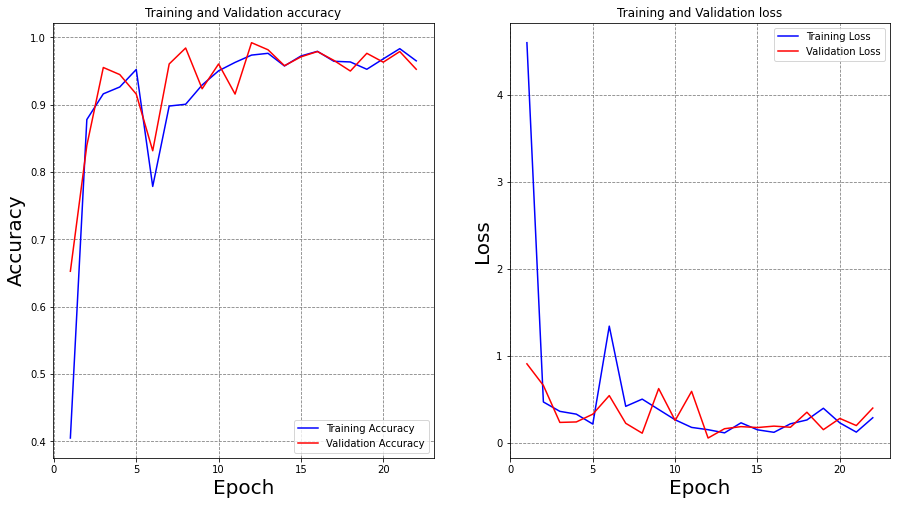

In [13]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(15,8))
    
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')

  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
    
  plt.show()
plotLearningCurve(r,n_epochs)

# Confusion Matrix

2022-11-29 08:59:23.426588: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 410400000 exceeds 10% of free system memory.
2022-11-29 08:59:24.112376: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 410400000 exceeds 10% of free system memory.
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


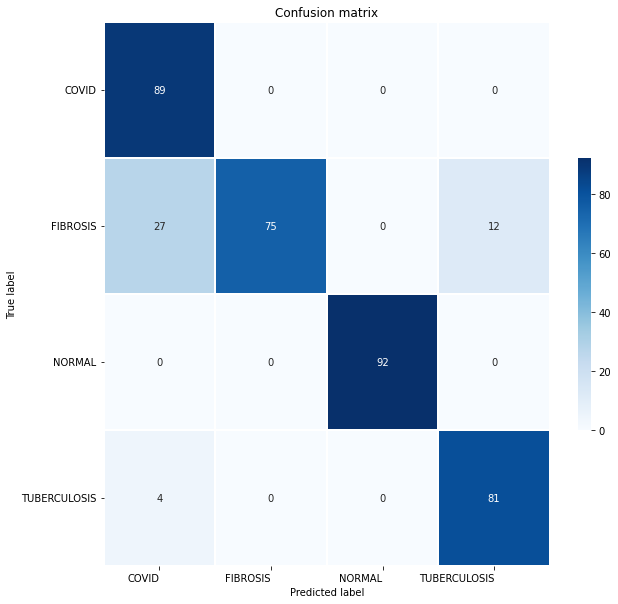

In [14]:
## plot confusion matrix
import copy

x = preprocess_input(copy.deepcopy(x_test))
y_preds = model.predict(x)
k = np.argmax(y_preds)
p = np.max(y_preds)

y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)


fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .5}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='Confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=0, ha='right', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

# Classification Report

In [15]:
x_test_2 = copy.deepcopy(x_test)
x = preprocess_input(x_test_2)
y_preds = model.predict(x)
y_preds = np.argmax(y_preds, axis=1)
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
dic = {0:'COVID', 1:'FIBROSIS', 2:'NORMAL', 3:'TUBERCULOSIS'}

print(classification_report(rounded_labels, y_preds, target_names=dic.values()))

2022-11-29 08:59:28.700807: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 410400000 exceeds 10% of free system memory.
2022-11-29 08:59:29.437785: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 410400000 exceeds 10% of free system memory.


              precision    recall  f1-score   support

       COVID       0.74      1.00      0.85        89
    FIBROSIS       1.00      0.66      0.79       114
      NORMAL       1.00      1.00      1.00        92
TUBERCULOSIS       0.87      0.95      0.91        85

    accuracy                           0.89       380
   macro avg       0.90      0.90      0.89       380
weighted avg       0.91      0.89      0.88       380



# ROC Curve

2022-11-29 08:59:33.141378: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 410400000 exceeds 10% of free system memory.


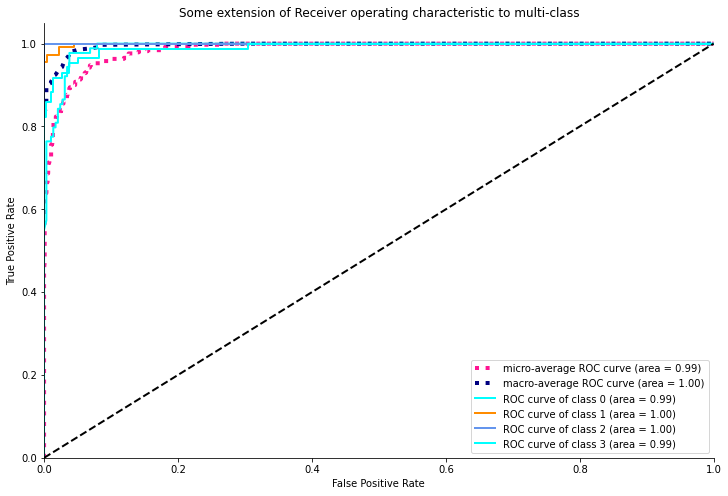

In [16]:
#ROC-AUC curve

import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
 


fpr = {}
tpr = {}
thresh ={}

n_classes = 4


x_test_2 = copy.deepcopy(x_test)
x = preprocess_input(x_test_2)
pred_Y = model.predict(x)


lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))


mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])


mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()